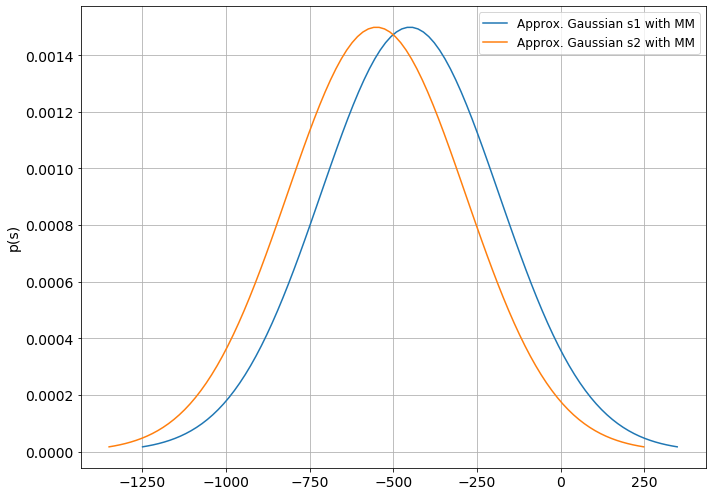

In [34]:
# Libraries
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import time

def gibbs_sampler(mu_1, mu_2, sigma_1, sigma_2, sigma_t, y, num_samples, burn_in):
    # Number of samples k
    k = num_samples
    
    # Storing vectors
    s_1 = np.zeros(burn_in+k)
    s_2 = np.zeros(burn_in+k)
    out = np.zeros(burn_in+k)
    
    # Set initial values
    s_1[0] = np.random.normal(mu_1, sigma_1)
    s_2[0] = np.random.normal(mu_2, sigma_2)
    
    for i in range(burn_in+k-1):
        mu_t = s_1[i] - s_2[i]
        if(y == 1):
            a, b = (0-mu_t)/sigma_t, np.infty
        else:
            a, b = -np.infty, (0-mu_t)/sigma_t
        # Calculate the output   
        out[i+1] = stats.truncnorm.rvs(a,b,mu_t,sigma_t)
        # Get sigma and Mu from the posterior to calculate the new prior
        Sigma = 1/(sigma_1+sigma_2+sigma_t)*np.matrix([[sigma_1*(sigma_2+sigma_t), sigma_1*sigma_2], \
                                                       [sigma_1*sigma_2, sigma_2*(sigma_1+sigma_t)]])
        Mu = np.matmul(Sigma, np.matrix([[mu_1/sigma_1+out[i+1]/sigma_t], [mu_2/sigma_2-out[i+1]/sigma_t]]))
        # Generate the new skills
        s_1[i+1], s_2[i+1] = np.random.multivariate_normal(list(Mu.flat), Sigma)
    
    # Discard burn-in samples
    s_1 = s_1[burn_in:-1]
    s_2 = s_2[burn_in:-1]
    
    return s_1, s_2, out

# Parameters
mu_BOTH = 50
sigma_BOTH = mu_BOTH/3
mu_1 = mu_BOTH
mu_2 = mu_BOTH
mus = mu_1 + mu_2
mu_t = mu_1 - mu_2
sigma_1 = sigma_BOTH
sigma_2 = sigma_BOTH
sigma_t = 10
sigmas = sigma_1 + sigma_2 + sigma_t
y = 1
num_samples = 500
burn_in = 25

# Get approximated from Gibbs sampler
s1,s2,out = gibbs_sampler(mu_1, mu_2, sigma_1, sigma_2, sigma_t, y, num_samples, burn_in)
# Approx Gaussian s1
mu_approx_s1 = np.mean(s1)
var_approx_s1 = np.var(s1)
sigma_approx_s1 = np.sqrt(var_approx_s1)
# Approx Gaussian s2
mu_approx_s2 = np.mean(s2)
var_approx_s2 = np.var(s2)
sigma_approx_s2 = np.sqrt(var_approx_s2)

# Get samples from truncated Gaussian
truncGaussian = stats.truncnorm.rvs((0-mu_t)/sigma_t,np.infty, mu_t, sigma_t, size=10000)
m_star = np.mean(truncGaussian)
sigma_star = np.var(truncGaussian)

alpha = (m_star*sigmas - mus*sigma_star)/(sigmas - sigma_star)
beta = sigma_star*sigmas/(sigmas - sigma_star)

# Get posteriors with moment matching
plt.figure(1, figsize=[10, 7])

plot(x_approx_s1, stats.norm.pdf(x_approx_s1, mu_approx_s1, sigma_approx_s1), label='Approx. Gaussian s1 with Gibbs')
plot(x_approx_s1, stats.norm.pdf(x_approx_s1, mu_approx_s1, sigma_approx_s1), label='Approx. Gaussian s1 with Gibbs')

s1_mu = alpha + mu_2
s1_sigma = beta + sigma_t + sigma_2
x_s1 = np.linspace(s1_mu - 3*s1_sigma, s1_mu + 3*s1_sigma, 100)
normal_s1 = stats.norm.pdf(x_s1, s1_mu, s1_sigma)
plt.plot(x_s1, normal_s1, label='Approx. Gaussian s1 with MM')

s2_mu = alpha - mu_1
s2_sigma = beta + sigma_t + sigma_1
x_s2 = np.linspace(s2_mu - 3*s2_sigma, s2_mu + 3*s2_sigma, 100)
normal_s2 = stats.norm.pdf(x_s2, s2_mu, s2_sigma)
plt.plot(x_s2, normal_s2, label='Approx. Gaussian s2 with MM')

# Plot settings
plt.legend(fontsize=12)
plt.grid(True)
plt.ylabel('p(s)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Show it
plt.savefig('_gaussian_approx_with_MM.pdf', format='pdf')
plt.show()